# Average treatment effect (thesis)

Date: 16 October 2025<br>
By: Eunhye Yang<br>
Description:<br>
1. ATE estimation through propensity score matching with caliper
2. ATE estimation through propensity score mathching & IPTW
3. ATE estimation through propensity score mathching & model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import wilcoxon
from statsmodels.formula.api import wls
import matplotlib.pyplot as plt

surgery = pd.read_csv('preprocessing/final_preprocessed_surgery_thesis.csv')
nosurgery = pd.read_csv('preprocessing/final_preprocessed_nosurgery_thesis.csv')

In [ ]:
surgery = surgery.drop(['@6MmRS', '@6Mmortality'], axis=1)
surgery = surgery.rename(columns={'TypeOfOT (1=clot evacuation, 2=EVD only)' : 'operation'})
nosurgery = nosurgery.drop(['@6MmRS', '@6Mmortality', 'ICHScore', 'mICHScore'], axis=1)
nosurgery['operation'] = 0

df = pd.concat([surgery, nosurgery])

# surgery vs no surgery
df.loc[df['operation'] == 2, 'operation'] = 1

# clot evacuation
# df = df[~(df['operation'] == 2)]

# EVD
# df = df[~(df['operation'] == 1)]
# df.loc[df['operation'] == 2, 'operation'] = 1

## Covariate

In [3]:
# no selection (all features)
# covariates = [i for i in df.columns if i not in ['operation', 'outcomes']]

# distribution comparison
# covariates = [
#     'Age', 'AdmissionsystolicBP', 'AdmissiondiastolicBP', 'LARGESTICHVOLUME',
#     'AdmissionGCS', 'Esubscore', 'Vsubscore', 'Msubscore', 'ULpower', 'LLpower',
#     'CKDclass', 'GRAEBSCORE', 'Anticoagulant0no1warfarin2NOAC',
#     'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe'
# ]

# Random Forest Regressor
covariates = [
    'Age', 'LARGESTICHVOLUME', 'GRAEBSCORE', 'AdmissionGCS', 'Admissionpulserate',
    'AdmissionsystolicBP', 'Esubscore', 'AdmissiondiastolicBP', 'Msubscore'
    'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe'
]

In [4]:
covariates_col = [col for col in df.columns if any(col.startswith(covariate) for covariate in covariates)]

## Propensity score calculation

In [5]:
X = df[covariates_col].copy()
y = df['operation'].copy()

In [6]:
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
propensity_score = ps_model.predict_proba(X)
propensity_score_surgery = propensity_score[np.where(y==1), 1][0]
propensity_score_nosurgery = propensity_score[np.where(y==0), 1][0]

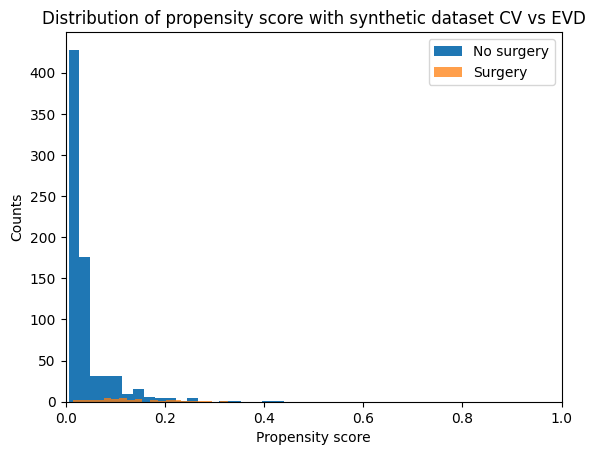

In [8]:
plt.hist(propensity_score_nosurgery, bins=20, label='No surgery')
plt.hist(propensity_score_surgery, bins=20, alpha=0.75, label='Surgery')
plt.ylabel('Counts')
plt.xlabel('Propensity score')
plt.title('Distribution of propensity score with synthetic dataset CV vs EVD')
plt.xlim(0, 1)
plt.legend()
plt.show()

## 1:1 caliper threshold matching

In [9]:
differences = []

for i, score_surgery in enumerate(propensity_score_surgery):
    for j, score_nosurgery in enumerate(propensity_score_nosurgery):
        differences.append([i, j, abs(score_nosurgery-score_surgery)])

differences = np.array(differences)

In [10]:
matched_surgery_idx = []
matched_nosurgery_idx = []
matched_pair = np.array([[-1, -1, -1]])

while len(matched_surgery_idx) != len(surgery):
    idx = np.argmin(differences[:,2])
    if min(differences[:,2]) > 0.2*np.std(propensity_score[:,1]): break
    pair = [int(differences[idx,0]), int(differences[idx,1]), differences[idx,2]]
    differences = np.delete(differences, np.argmin(differences[:,2]), axis=0)
    if pair[0] in matched_surgery_idx: continue
    if pair[1] in matched_nosurgery_idx: continue
    matched_pair = np.append(matched_pair, [pair], axis=0)
    matched_surgery_idx.append(pair[0])
    matched_nosurgery_idx.append(pair[1])

matched_pair = matched_pair[1:]

In [11]:
print(f'Number of matched pairs: {len(matched_pair)}')
print(f'Caliper value: {0.2*np.std(propensity_score[:,1]):.4f}')
print(f'Average differences of propensity score for caliper 1:1 matching: {np.mean(matched_pair[:,2]):.6f}')
print(f'Standard deviation of differences of propensity score for caliper 1:1 matching: {np.std(matched_pair[:,2]):.6f}')

Number of matched pairs: 33
Caliper value: 0.0107
Average differences of propensity score for caliper 1:1 matching: 0.000943
Standard deviation of differences of propensity score for caliper 1:1 matching: 0.001377


In [12]:
treatment_effect = []
outcome_pair = []

for pair in matched_pair:
    treatment_effect.append(nosurgery['outcomes'].loc[pair[1]] - surgery['outcomes'].loc[pair[0]])
    outcome_pair.append([pair[0], pair[1]])

## Propensity match ATE

In [13]:
ate = np.mean(treatment_effect)
std = np.std(treatment_effect)
print(f'Average Treatment Effect (ATE) with caliper 1:1 matching: {ate:.3f}')
print(f'95% Confidence Interval for ATE for caliper 1:1 matching: ({ate-(1.96*(std/np.sqrt(len(treatment_effect)))):.4f}, {ate+(1.96*(std/np.sqrt(len(treatment_effect)))):.4f})')
print(f'(±{1.96*(std/np.sqrt(len(treatment_effect)))})')

Average Treatment Effect (ATE) with caliper 1:1 matching: 0.545
95% Confidence Interval for ATE for caliper 1:1 matching: (0.2302, 0.8608)
(±0.31530193485935654)


In [14]:
matched_surgery_df = surgery.loc[matched_pair[:,0]]
matched_surgery_df['propensity_score'] = propensity_score_surgery[[int(i) for i in matched_pair[:,0]]]

matched_nosurgery_df = nosurgery.loc[matched_pair[:,1]]
matched_nosurgery_df['propensity_score'] = propensity_score_nosurgery[[int(i) for i in matched_pair[:,1]]]

print(wilcoxon(matched_nosurgery_df['outcomes'], matched_surgery_df['outcomes'], alternative='greater'))

WilcoxonResult(statistic=np.float64(282.0), pvalue=np.float64(0.0017340165827951172))


## IPTW-ATE

In [15]:
matched_df = pd.concat([matched_surgery_df, matched_nosurgery_df])
matched_df['weight'] = np.where(matched_df['operation'] == 1, 1/matched_df['propensity_score'], 1/(1-matched_df['propensity_score']))
matched_df = matched_df.drop(['propensity_score'], axis=1)

In [16]:
wls_model = wls('outcomes ~ operation', data=matched_df, weights=matched_df['weight']).fit()
print(f"Statistical significance of operation on outcomes: p-value = {wls_model.pvalues['operation']}")
if wls_model.pvalues['operation'] < 0.05:
    print('Operation affects the outcomes statistically signficantly.')
else:
    print('Operation does not affect the outcomes.')

Statistical significance of operation on outcomes: p-value = 0.011860773340405363
Operation affects the outcomes statistically signficantly.


In [17]:
ate = wls_model.params['operation']
print(f'Average Treatment Effect (ATE) using IPTW: {-1*ate:.3f}')

Average Treatment Effect (ATE) using IPTW: 0.341


In [18]:
conf_int = wls_model.conf_int().loc['operation']
print(f'95% Confidence Interval for ATE using IPTW: ({-1*conf_int[1]:.4f}, {-1*conf_int[0]:.4f})')
print(conf_int[1] - ate)

95% Confidence Interval for ATE using IPTW: (0.0781, 0.6045)
0.26319989794883364
